In [1]:
import cgmquantify as cgm
import pandas as pd
import datetime as datetime
from datetime import date
from scipy.stats import stats
import numpy as np
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from scipy.signal import find_peaks
from scipy.stats import stats

from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from numpy import mean
from numpy import absolute
from numpy import sqrt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!pip install cgmquantify

In [ ]:
!pip install tslearn

In [ ]:
!pip install imbalanced-learn

In [2]:
df_merged_all = pd.read_csv('df_overnight_and_PRO.csv', sep='\t')


In [152]:
df_merged_all

,Unnamed: 0,id,time,gl,phase,label,axis1,axis2,axis3,steps,lux,inclineOff,inclineStanding,inclineSitting,inclineLying,vm,joinID
0,0,1,2020-06-23 12:38:00+00:00,125.0,screening,Undefined,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,2020-06-23 12:45:00+00:00,120.0,screening,Undefined,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1,2020-06-23 12:45:00+00:00,121.0,screening,Undefined,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1,2020-06-23 12:53:00+00:00,114.0,screening,Undefined,705.0,593.0,1321.0,8.0,0.0,0.0,60.0,0.0,0.0,1611.0,NaN
4,4,1,2020-06-23 13:09:00+00:00,107.0,screening,Undefined,363.0,266.0,578.0,16.0,0.0,0.0,0.0,1.0,59.0,733.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112974,112974,47,2021-12-07 07:06:00+00:00,108.0,lTRE,Undefined,5565.0,5930.0,5865.0,36.0,0.0,0.0,60.0,0.0,0.0,10027.0,NaN
112975,112975,47,2021-12-07 07:21:00+00:00,110.0,lTRE,Undefined,2043.0,2564.0,3787.0,15.0,0.0,0.0,60.0,0.0,0.0,5009.0,NaN
112976,112976,47,2021-12-07 07:36:00+00:00,110.0,lTRE,Undefined,NaN,171.0,112.0,0.0,0.0,0.0,15.0,45.0,0.0,205.0,47.lTRE.2021-12-07
112977,112977,47,2021-12-07 07:51:00+00:00,109.0,lTRE,Undefined,4.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,60.0,4.0,NaN


In [3]:
df_merged_all = df_merged_all.dropna(subset=['axis1', 'axis2', 'axis3'],how='all')

df_merged_all['axis1'] = df_merged_all['axis1'].fillna(0)
df_merged_all['axis2'] = df_merged_all['axis2'].fillna(0)
df_merged_all['axis3'] = df_merged_all['axis3'].fillna(0)

df_merged_all['time'] = pd.to_datetime(df_merged_all['time'] ,errors = 'coerce')

df_merged_all = df_merged_all.reset_index(drop=True)
df_merged_all = df_merged_all.drop(["Unnamed: 0", "joinID"], axis=1)

fasting_states_to_keep = ['fasting', 'non-fasting']
df_merged_all = df_merged_all[df_merged_all.label.isin(fasting_states_to_keep)]

#phases_to_keep = ['lTRE', 'eTRE']
#df_merged_all = df_merged_all[df_merged_all.phase.isin(phases_to_keep)]

final_df = df_merged_all.sort_values(by=['id', 'time', "phase"], ascending=True)

In [4]:
final_df['Time'] = pd.to_datetime(final_df['time'], format='%Y-%m-%dT%H:%M:%S')
final_df['Glucose'] = pd.to_numeric(final_df['gl'])
final_df['Day'] = final_df["Time"].dt.date
final_df = final_df.reset_index(drop=True)

In [5]:
df_train = final_df[final_df['id'] > 8]
df_test = final_df[final_df['id'] <= 8]

In [120]:
id_test = [2, 10, 12, 17, 19, 23, 35, 34, 38, 41, 45]

In [121]:
df_test = final_df.loc[final_df['id'].isin(id_test)] 
df_train = final_df.loc[~final_df['id'].isin(id_test)] 

## Label Encoding

In [6]:
map_dict = {"non-fasting": 1, "fasting":0}
df_train["label"] = df_train["label"].map(map_dict)
df_test["label"] = df_test["label"].map(map_dict)

In [7]:
map_dict = {"screening": 1, "lTRE":0, "eTRE":2}
df_train["phase"] = df_train["phase"].map(map_dict)
df_test["phase"] = df_test["phase"].map(map_dict)

In [8]:
df_train

,id,time,gl,phase,label,axis1,axis2,axis3,steps,lux,inclineOff,inclineStanding,inclineSitting,inclineLying,vm,Time,Glucose,Day
5204,10,2020-09-14 23:04:00+00:00,86.0,0,0,66.0,16.0,70.0,1.0,0.0,0.0,0.0,59.0,1.0,98.0,2020-09-14 23:04:00+00:00,86.0,2020-09-14
5205,10,2020-09-14 23:19:00+00:00,87.0,0,0,159.0,366.0,455.0,2.0,0.0,0.0,0.0,17.0,43.0,606.0,2020-09-14 23:19:00+00:00,87.0,2020-09-14
5206,10,2020-09-14 23:36:00+00:00,101.0,0,0,305.0,502.0,462.0,5.0,0.0,0.0,0.0,31.0,29.0,748.0,2020-09-14 23:36:00+00:00,101.0,2020-09-14
5207,10,2020-09-14 23:46:00+00:00,96.0,0,0,118.0,171.0,270.0,0.0,0.0,0.0,0.0,48.0,12.0,341.0,2020-09-14 23:46:00+00:00,96.0,2020-09-14
5208,10,2020-09-14 23:51:00+00:00,95.0,0,0,89.0,95.0,410.0,1.0,0.0,0.0,0.0,0.0,60.0,431.0,2020-09-14 23:51:00+00:00,95.0,2020-09-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34939,47,2021-12-07 02:21:00+00:00,108.0,0,0,421.0,466.0,296.0,5.0,0.0,0.0,60.0,0.0,0.0,695.0,2021-12-07 02:21:00+00:00,108.0,2021-12-07
34940,47,2021-12-07 02:51:00+00:00,112.0,0,0,180.0,716.0,255.0,2.0,0.0,40.0,0.0,0.0,20.0,782.0,2021-12-07 02:51:00+00:00,112.0,2021-12-07
34941,47,2021-12-07 03:21:00+00:00,103.0,0,0,740.0,521.0,251.0,1.0,0.0,0.0,60.0,0.0,0.0,940.0,2021-12-07 03:21:00+00:00,103.0,2021-12-07
34942,47,2021-12-07 03:36:00+00:00,102.0,0,0,486.0,536.0,260.0,2.0,0.0,0.0,60.0,0.0,0.0,769.0,2021-12-07 03:36:00+00:00,102.0,2021-12-07


## Windowing

In [8]:
x_list_train = []
train_labels = []


window_size = 3
step_size = 1

# creating overlaping windows of size window-size 100
for i in range(0, df_train.shape[0] - window_size, step_size):
    id_p = df_train['id'].values[i: i + window_size]
    phase = df_train['phase'].values[i: i + window_size]
    time = df_train['Time'].values[i: i + window_size]
    times = df_train['Day'].values[i: i + window_size]
    gls = df_train['Glucose'].values[i: i + window_size]
    steps = df_train['steps'].values[i: i + window_size]
    inclineStanding = df_train['inclineStanding'].values[i: i + window_size]
    inclineSitting = df_train['inclineSitting'].values[i: i + window_size]
    inclineLying = df_train['inclineLying'].values[i: i + window_size]
    
    timedelta_first = time[1] - time[0]
    timedelta_second = time[2] - time[1]
    one_hour = 3600000000000
    
    if (timedelta_first < one_hour and timedelta_second < one_hour):
   
    
        xs = df_train['axis1'].values[i: i + window_size]
        ys = df_train['axis2'].values[i: i + window_size]
        zs = df_train['axis3'].values[i: i + window_size]

        label = stats.mode(df_train['label'][i: i + window_size])[0][0]

        df_slice = pd.DataFrame(time, columns=['Time'])
        df_slice["id"] = id_p
        df_slice["phase"] = phase
        df_slice["Day"] = times
        df_slice["Glucose"] = gls   
        df_slice["axis1"] = xs
        df_slice["axis2"] = ys
        df_slice["axis3"] = zs
        df_slice["steps"] = steps
        df_slice["inclineStanding"] = inclineStanding
        df_slice["inclineSitting"] = inclineSitting
        df_slice["inclineLying"] = inclineLying

        x_list_train.append(df_slice)

        train_labels.append(label)

In [9]:
x_list_test = []
test_labels = []


window_size = 3
step_size = 1

# creating overlaping windows of size window-size 100
for i in range(0, df_test.shape[0] - window_size, step_size):
    id_p = df_test['id'].values[i: i + window_size]
    phase = df_test['phase'].values[i: i + window_size]
    time = df_test['Time'].values[i: i + window_size]
    times = df_test['Day'].values[i: i + window_size]
    gls = df_test['Glucose'].values[i: i + window_size]
    steps = df_train['steps'].values[i: i + window_size]
    inclineStanding = df_test['inclineStanding'].values[i: i + window_size]
    inclineSitting = df_test['inclineSitting'].values[i: i + window_size]
    inclineLying = df_test['inclineLying'].values[i: i + window_size]
    
    timedelta_first = time[1] - time[0]
    timedelta_second = time[2] - time[1]
    one_hour = 3600000000000
    
    if (timedelta_first < one_hour and timedelta_second < one_hour):
    
        xs = df_test['axis1'].values[i: i + window_size]
        ys = df_test['axis2'].values[i: i + window_size]
        zs = df_test['axis3'].values[i: i + window_size]

        label = stats.mode(df_test['label'][i: i + window_size])[0][0]

        df_slice = pd.DataFrame(time, columns=['Time'])
        df_slice["id"] = id_p
        df_slice["phase"] = phase
        df_slice["Day"] = times
        df_slice["Glucose"] = gls     
        df_slice["axis1"] = xs
        df_slice["axis2"] = ys
        df_slice["axis3"] = zs
        df_slice["steps"] = steps
        df_slice["inclineStanding"] = inclineStanding
        df_slice["inclineSitting"] = inclineSitting
        df_slice["inclineLying"] = inclineLying

        x_list_test.append(df_slice)

        test_labels.append(label)

## Feature computation

In [10]:
def feat_statistical_measures_gl_acc(x_list):
    X_train = pd.DataFrame()

    for df_temp in x_list:
        
        id_p = df_temp.loc[1,'id']
        phase = df_temp.loc[1,'phase']
        time_median = df_temp.loc[1,'Time']
        
        cgm_summary = list(cgm.summary(df_temp))
        cgm_J_index = cgm.J_index(df_temp)

        cgm_interdaycv = cgm.interdaycv(df_temp)

        cgm_summary.append(cgm_J_index)
        cgm_summary.append(cgm_interdaycv)

        
        
        # mean
        z_mean = df_temp["axis3"].mean()

        # max
        y_max = df_temp["axis2"].max()


        # energy
        z_energy = ((df_temp["axis3"] **2) / 100).sum()
        
        general = []
        general.extend([id_p, phase, time_median])


        acc_summary = []
        acc_summary.extend([z_mean, y_max ,z_energy])
        

        features = general
        features.extend(cgm_summary)
        features.extend(acc_summary)

        X_train_temp = pd.DataFrame([features], columns = ["id", "phase","time","mean", "median","minimum", "maximum","first_quartile", "third_quartile",
                                                              "J_index","cgm_interdaycv", 
                                                              "z_mean", "y_max", "z_energy"])

        
        X_train = pd.concat([X_train, X_train_temp], ignore_index=True)
        
    return X_train

In [11]:
def feat_statistical_measures_gl_tsc(x_list):
    X_train = pd.DataFrame()

    for df_temp in x_list:
        time_median = df_temp.loc[1,'Time']
        cgm_summary = list(cgm.summary(df_temp))
        cgm_LBGI = cgm.LBGI(df_temp)
        cgm_HBGI = cgm.HBGI(df_temp)
        cgm_ADRR = cgm.ADRR(df_temp)
        cgm_GMI = cgm.GMI(df_temp)
        cgm_J_index = cgm.J_index(df_temp)
        cgm_eA1c = cgm.eA1c(df_temp)
        cgm_interdaysd = cgm.interdaysd(df_temp)
        cgm_interdaycv = cgm.interdaycv(df_temp)

        cgm_summary.append(cgm_LBGI)
        cgm_summary.append(cgm_HBGI)
        cgm_summary.append(cgm_ADRR)
        cgm_summary.append(cgm_GMI)
        cgm_summary.append(cgm_J_index)
        cgm_summary.append(cgm_eA1c)
        cgm_summary.append(cgm_interdaysd)
        cgm_summary.append(cgm_interdaycv)




        general = []
        general.extend([time_median])
        general.extend(cgm_summary)

        X_train_temp = pd.DataFrame([general],
                                    columns=["time","mean", "median", "minimum", "maximum", "first_quartile", "third_quartile",
                                             "LBGI", "HBGI", "ADRR", "GMI", "J_index", "eA1c", "interdaysd",
                                             "cgm_interdaycv"])

        X_train = pd.concat([X_train, X_train_temp], ignore_index=True)
        
    return X_train

In [12]:

def feat_statistical_measures_acc_tsc(x_list):
    X_train = pd.DataFrame()

    for df_temp in x_list:
        time_median = df_temp.loc[1,'Time']

        # mean
        z_mean = df_temp["axis3"].mean()

        # max
        y_max = df_temp["axis2"].max()


        # energy
        z_energy = ((df_temp["axis3"] **2) / 100).sum()

        general = []
        general.extend([time_median])

        acc_summary = []
        acc_summary.extend([z_mean, y_max ,z_energy])
        
        features = general
        features.extend(acc_summary)

        X_train_temp = pd.DataFrame([features],
                                    columns=["time","z_mean", "y_max", "z_energy"])

        X_train = pd.concat([X_train, X_train_temp], ignore_index=True)

    return X_train


In [11]:

X_test = feat_statistical_measures_gl_acc(x_list_test)

X_train = feat_statistical_measures_gl_acc(x_list_train)

In [126]:
X_test = feat_statistical_measures_gl_tsc(x_list_test)

X_train = feat_statistical_measures_gl_tsc(x_list_train)

In [127]:
X_test

,time,mean,median,minimum,maximum,first_quartile,third_quartile,LBGI,HBGI,ADRR,GMI,J_index,eA1c,interdaysd,cgm_interdaycv
0,2020-07-20 23:40:00,105.333333,105.0,102.0,109.0,103.5,107.0,0.178242,0.0,0.184440,5.829573,11.707408,5.297329,2.867442,2.722255
1,2020-07-21 00:25:00,103.333333,102.0,99.0,109.0,100.5,105.5,0.312155,0.0,0.450728,5.781733,11.561253,5.227642,4.189935,4.054776
2,2020-07-21 00:40:00,96.000000,99.0,80.0,109.0,89.5,104.0,1.539269,0.0,4.015211,5.606320,11.669994,4.972125,12.027746,12.528902
3,2020-07-21 00:55:00,78.666667,80.0,57.0,99.0,68.5,89.5,6.813781,0.0,15.858545,5.191707,9.185113,4.368177,17.172329,21.829232
4,2020-07-21 01:40:00,66.333333,62.0,57.0,80.0,59.5,71.0,10.691067,0.0,15.858545,4.896693,5.808018,3.938444,9.877022,14.889982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4599,2020-12-08 23:49:00,86.333333,86.0,83.0,90.0,84.5,88.0,2.472824,0.0,2.846894,5.375093,7.956778,4.635308,2.867442,3.321361
4600,2020-12-09 00:04:00,86.333333,86.0,83.0,90.0,84.5,88.0,2.472824,0.0,2.846894,5.375093,7.956778,4.635308,2.867442,3.321361
4601,2020-12-09 00:49:00,88.333333,89.0,86.0,90.0,87.5,89.5,2.040752,0.0,2.496359,5.422933,8.105942,4.704994,1.699673,1.924158
4602,2020-12-09 02:19:00,89.000000,88.0,88.0,91.0,88.0,89.5,1.911803,0.0,2.088438,5.438880,8.174730,4.728223,1.414214,1.589004


In [161]:
X_test = feat_statistical_measures_acc_tsc(x_list_test)

X_train = feat_statistical_measures_acc_tsc(x_list_train)

## Saving and Loading the featured Data

In [12]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [13]:
X_test.to_csv("TSC_data/eval_Xtest.csv", sep='\t')
X_train.to_csv("TSC_data/eval_Xrain.csv", sep='\t')


In [14]:
y_train_float = y_train
y_test_float = y_test

In [15]:
np.save('TSC_data/eval_y_train.npy', y_train_float)
np.save('TSC_data/eval_y_test.npy', y_test_float)

In [2]:
X_test = pd.read_csv('eval_Xtest.csv', sep='\t')
X_train = pd.read_csv('eval_Xrain.csv', sep='\t')

X_test = X_test.drop(["Unnamed: 0"], axis=1)
X_train = X_train.drop(["Unnamed: 0"], axis=1)

In [3]:
y_train_float = np.load('TSC_data\\eval_y_train.npy')
y_test_float = np.load('TSC_data\\eval_y_test.npy')

In [16]:
mylist = list(set(y_train_float))
mylist

[0, 1]

## Feature Selection

In [5]:
X_train_rfe = X_train.drop(["time"], axis=1)
X_test_rfe = X_test.drop(["time"], axis=1)

In [151]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE

# fit random forest model
model = RandomForestRegressor(n_estimators=500, random_state=1)
model.fit(X_train_rfe, y_train_float)
# show importance scores
print(model.feature_importances_)

[5.16320996e-02 4.18759784e-03 3.66450911e-03 7.28349859e-03
 7.08943778e-03 6.59146557e-02 5.84648914e-03 6.24351537e-03
 7.62179197e-03 3.04654910e-03 1.70696367e-02 3.80105328e-03
 6.65704010e-02 3.87340560e-03 2.25717443e-02 1.89382390e-02
 9.17063220e-04 1.05469729e-03 9.39917492e-04 4.81597060e-03
 4.88398482e-03 1.13064606e-02 1.56488576e-02 8.84865293e-02
 6.75930342e-03 6.95217821e-03 6.43387174e-03 8.31757565e-03
 8.62183644e-03 8.28476736e-03 1.14586273e-02 1.56753991e-02
 1.65392713e-02 1.05640273e-02 1.35749198e-02 1.44488118e-02
 5.78439171e-03 6.45022769e-03 6.18200490e-03 1.39085170e-02
 2.31742488e-02 1.62075026e-02 1.47804813e-02 1.84207259e-02
 1.58188132e-02 5.98365373e-03 6.43872478e-03 5.98863220e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 9.42490916e-04
 9.98617755e-04 1.23300638e-03 5.16422687e-04 4.15210789e-04
 4.85042924e-04 9.66635012e-04 9.34103174e-04 9.45332627e-04
 1.45105413e-02 1.49928122e-02 1.54667263e-02 2.26838701e-05
 1.07029519e-05 6.180616

In [ ]:
from sklearn.feature_selection import RFE

rfe = RFE(RandomForestRegressor(n_estimators=500, random_state=1), n_features_to_select=4)
fit = rfe.fit(X_train_rfe, y_train_float)
# report selected features
print('Selected Features:')


In [158]:
fit.ranking_

array([ 6, 45, 53, 35, 37,  4, 43, 40, 24, 54, 13, 50,  1, 47, 15,  3, 62,
       55, 57, 51, 30, 22, 11,  1, 41, 39, 42, 18, 19, 27, 29, 20, 12,  2,
        1, 14, 49, 28, 48,  8,  5, 16, 17, 10,  9, 34, 46, 33, 72, 71, 70,
       61, 60, 56, 64, 65, 66, 58, 63, 59, 25, 23, 21, 67, 68, 69, 31, 26,
        1, 32, 44,  7, 52, 36, 38])

In [159]:
fit.support_

array([False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False])

In [161]:
for i in range(len(fit.support_)):
    if fit.support_[i]:
        print(names[i])

J_index
z_mean
y_max
z_energy


In [7]:
names

array(['id', 'phase', 'mean', 'median', 'minimum', 'maximum',
       'first_quartile', 'third_quartile', 'LBGI', 'HBGI', 'ADRR', 'GMI',
       'J_index', 'eA1c', 'interdaysd', 'cgm_interdaycv', 'cgm_TOR',
       'cgm_TIR', 'cgm_POR', 'cgm_MAGN', 'cgm_MAGE', 'x_mean', 'y_mean',
       'z_mean', 'x_std', 'y_std', 'z_std', 'x_aad', 'y_aad', 'z_aad',
       'x_min', 'y_min', 'z_min', 'x_max', 'y_max', 'z_max',
       'x_maxmin_diff', 'y_maxmin_diff', 'z_maxmin_diff', 'x_median',
       'y_median', 'z_median', 'x_mad', 'y_mad', 'z_mad', 'x_IQR',
       'y_IQR', 'z_IQR', 'x_neg_count', 'y_neg_count', 'z_neg_count',
       'x_pos_count', 'y_pos_count', 'z_pos_count', 'x_above_mean',
       'y_above_mean', 'z_above_mean', 'x_peak_count', 'y_peak_count',
       'z_peak_count', 'x_skewness', 'y_skewness', 'z_skewness',
       'x_kurtosis', 'y_kurtosis', 'z_kurtosis', 'x_energy', 'y_energy',
       'z_energy', 'avg_result_accl', 'sma', 'steps', 'inclineStanding',
       'inclineSitting'], dtype=o

In [6]:
names = X_train_rfe.columns.values[0:-1]


In [ ]:
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
X, y = make_friedman1(n_samples=50, n_features=5, random_state=0)
estimator = SVR(kernel="linear")
selector = RFE(estimator, n_features_to_select=5, step=1)
selector = selector.fit(X_train_rfe, y_train_float)



In [ ]:
selector.ranking_

In [43]:
n_features_to_select = 10
rfe = RFE(regressor, n_features_to_select=n_features_to_select)
rfe.fit(X_train_rfe, y_train_float)
predictions_rfe = rfe.predict(X_test_rfe)

In [47]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, predictions_rfe))


Accuracy: 0.720225914709012


In [ ]:
from operator import itemgetter
features = X_train.columns.to_list()
for x, y in (sorted(zip(selector.ranking_ , features), key=itemgetter(0))):
    print(x, y)

## Building the time series

In [26]:
mylist = list(set(y_test_float))

mylist

[0, 1]

### Test-dataset

### acc and gl

In [4]:
from datetime import datetime


X_test.time = pd.to_datetime(X_test.time)

x_list_test_tsc_1st = []
test_labels_tsc = []
x_list_test_tsc_2nd = []
counter=0


last_time_before = X_test['time'].values[0]

for i in range(0, X_test.shape[0], 1):
    time = X_test['time'].values[i]
    cgm_interdaycv =  X_test['cgm_interdaycv'].values[i]
    J_index = X_test['J_index'].values[i]
    maximum = X_test['maximum'].values[i]
    z_mean = X_test['z_mean'].values[i]
    y_max = X_test['y_max'].values[i]
    z_energy = X_test['z_energy'].values[i]
    
    timedelta_first =  time - last_time_before

    one_hour = 3600000000000
    
    if timedelta_first < one_hour and counter < 5:
        x_list_test_tsc_3rd = []
        x_list_test_tsc_3rd.append(cgm_interdaycv)
        x_list_test_tsc_3rd.append(J_index)
        x_list_test_tsc_3rd.append(maximum)
        x_list_test_tsc_3rd.append(z_mean)
        x_list_test_tsc_3rd.append(y_max)
        x_list_test_tsc_3rd.append(z_energy)
        x_list_test_tsc_2nd.append(x_list_test_tsc_3rd)
    
    else:
        
        if counter == 5:
            x_list_test_tsc_1st.append(x_list_test_tsc_2nd)
            test_labels_tsc.append(y_test_float[i])
            
        counter = 0
        x_list_test_tsc_2nd = [] 
        x_list_test_tsc_3rd = []
        x_list_test_tsc_3rd.append(cgm_interdaycv)
        x_list_test_tsc_3rd.append(J_index)
        x_list_test_tsc_3rd.append(maximum)
        x_list_test_tsc_3rd.append(z_mean)
        x_list_test_tsc_3rd.append(y_max)
        x_list_test_tsc_3rd.append(z_energy)
        x_list_test_tsc_2nd.append(x_list_test_tsc_3rd)
        
    counter += 1
    
    last_time_before = time


### gl

In [42]:
from datetime import datetime


X_test.time = pd.to_datetime(X_test.time)

x_list_test_tsc_1st = []
test_labels_tsc = []
x_list_test_tsc_2nd = []
counter=0


last_time_before = X_test['time'].values[0]

for i in range(0, X_test.shape[0], 1):
    time = X_test['time'].values[i]
    cgm_interdaycv =  X_test['cgm_interdaycv'].values[i]
    J_index = X_test['J_index'].values[i]
    maximum = X_test['maximum'].values[i]
    
    timedelta_first =  time - last_time_before

    one_hour = 3600000000000
    
    if timedelta_first < one_hour and counter < 5:
        x_list_test_tsc_3rd = []
        x_list_test_tsc_3rd.append(cgm_interdaycv)
        x_list_test_tsc_3rd.append(J_index)
        x_list_test_tsc_3rd.append(maximum)

        x_list_test_tsc_2nd.append(x_list_test_tsc_3rd)
    
    else:
        
        if counter == 5:
            x_list_test_tsc_1st.append(x_list_test_tsc_2nd)
            test_labels_tsc.append(y_test_float[i])
            
        counter = 0
        x_list_test_tsc_2nd = [] 
        x_list_test_tsc_3rd = []
        x_list_test_tsc_3rd.append(cgm_interdaycv)
        x_list_test_tsc_3rd.append(J_index)
        x_list_test_tsc_3rd.append(maximum)
        x_list_test_tsc_2nd.append(x_list_test_tsc_3rd)
        
    counter += 1
    
    last_time_before = time

### acc

In [166]:
from datetime import datetime


X_test.time = pd.to_datetime(X_test.time)

x_list_test_tsc_1st = []
test_labels_tsc = []
x_list_test_tsc_2nd = []
counter=0


last_time_before = X_test['time'].values[0]

for i in range(0, X_test.shape[0], 1):
    time = X_test['time'].values[i]
    z_mean = X_test['z_mean'].values[i]
    y_max = X_test['y_max'].values[i]
    z_energy = X_test['z_energy'].values[i]
    
    timedelta_first =  time - last_time_before

    one_hour = 3600000000000
    
    if timedelta_first < one_hour and counter < 5:
        x_list_test_tsc_3rd = []

        x_list_test_tsc_3rd.append(z_mean)
        x_list_test_tsc_3rd.append(y_max)
        x_list_test_tsc_3rd.append(z_energy)
        x_list_test_tsc_2nd.append(x_list_test_tsc_3rd)
    
    else:
        
        if counter == 5:
            x_list_test_tsc_1st.append(x_list_test_tsc_2nd)
            test_labels_tsc.append(y_test_float[i])
            
        counter = 0
        x_list_test_tsc_2nd = [] 
        x_list_test_tsc_3rd = []

        x_list_test_tsc_3rd.append(z_mean)
        x_list_test_tsc_3rd.append(y_max)
        x_list_test_tsc_3rd.append(z_energy)
        x_list_test_tsc_2nd.append(x_list_test_tsc_3rd)
        
    counter += 1
    
    last_time_before = time

### Train-Dataset

In [5]:
from datetime import datetime


X_train.time = pd.to_datetime(X_train.time)


x_list_train_tsc_1st = []
train_labels_tsc = []
x_list_train_tsc_2nd = []
counter = 0


last_time_before = X_train['time'].values[0]



for i in range(0, X_train.shape[0], 1):
    time = X_train['time'].values[i]
    cgm_interdaycv =  X_train['cgm_interdaycv'].values[i]
#     steps =  X_train['steps'].values[i]
#     interdaysd =  X_train['interdaysd'].values[i]
#     cgm_MAGE =  X_train['cgm_MAGE'].values[i]
    J_index = X_train['J_index'].values[i]
    maximum = X_train['maximum'].values[i]
    z_mean = X_train['z_mean'].values[i]
    y_max = X_train['y_max'].values[i]
    z_energy = X_train['z_energy'].values[i]
    
    timedelta_first =  time - last_time_before

    one_hour = 3600000000000
    
    if timedelta_first < one_hour and counter < 5:
        
        x_list_train_tsc_3rd = []
        x_list_train_tsc_3rd.append(cgm_interdaycv)
        x_list_train_tsc_3rd.append(J_index)
        x_list_train_tsc_3rd.append(maximum)
        x_list_train_tsc_3rd.append(z_mean)
        x_list_train_tsc_3rd.append(y_max)
        x_list_train_tsc_3rd.append(z_energy)
        x_list_train_tsc_2nd.append(x_list_train_tsc_3rd)
    
    else:
        if counter == 5:
            x_list_train_tsc_1st.append(x_list_train_tsc_2nd)
            train_labels_tsc.append(y_train_float[i])
            
        counter = 0
        x_list_train_tsc_2nd = [] 
        x_list_train_tsc_3rd = []
        x_list_train_tsc_3rd.append(cgm_interdaycv)
        x_list_train_tsc_3rd.append(J_index)
        x_list_train_tsc_3rd.append(maximum)
        x_list_train_tsc_3rd.append(z_mean)
        x_list_train_tsc_3rd.append(y_max)
        x_list_train_tsc_3rd.append(z_energy)
        x_list_train_tsc_2nd.append(x_list_train_tsc_3rd)
    counter += 1
    last_time_before = time

### gl

In [43]:
from datetime import datetime


X_train.time = pd.to_datetime(X_train.time)


x_list_train_tsc_1st = []
train_labels_tsc = []
x_list_train_tsc_2nd = []
counter = 0


last_time_before = X_train['time'].values[0]



for i in range(0, X_train.shape[0], 1):
    time = X_train['time'].values[i]
    cgm_interdaycv =  X_train['cgm_interdaycv'].values[i]
    J_index = X_train['J_index'].values[i]
    maximum = X_train['maximum'].values[i]
    
    timedelta_first =  time - last_time_before

    one_hour = 3600000000000
    
    if timedelta_first < one_hour and counter < 5:
        
        x_list_train_tsc_3rd = []
        x_list_train_tsc_3rd.append(cgm_interdaycv)
        x_list_train_tsc_3rd.append(J_index)
        x_list_train_tsc_3rd.append(maximum)

        x_list_train_tsc_2nd.append(x_list_train_tsc_3rd)
    
    else:
        if counter == 5:
            x_list_train_tsc_1st.append(x_list_train_tsc_2nd)
            train_labels_tsc.append(y_train_float[i])
            
        counter = 0
        x_list_train_tsc_2nd = [] 
        x_list_train_tsc_3rd = []
        x_list_train_tsc_3rd.append(cgm_interdaycv)
        x_list_train_tsc_3rd.append(J_index)
        x_list_train_tsc_3rd.append(maximum)

        x_list_train_tsc_2nd.append(x_list_train_tsc_3rd)
    counter += 1
    last_time_before = time

### acc

In [167]:
from datetime import datetime


X_train.time = pd.to_datetime(X_train.time)


x_list_train_tsc_1st = []
train_labels_tsc = []
x_list_train_tsc_2nd = []
counter = 0


last_time_before = X_train['time'].values[0]



for i in range(0, X_train.shape[0], 1):
    time = X_train['time'].values[i]
    z_mean = X_train['z_mean'].values[i]
    y_max = X_train['y_max'].values[i]
    z_energy = X_train['z_energy'].values[i]
    
    timedelta_first =  time - last_time_before

    one_hour = 3600000000000
    
    if timedelta_first < one_hour and counter < 5:
        
        x_list_train_tsc_3rd = []
        x_list_train_tsc_3rd.append(z_mean)
        x_list_train_tsc_3rd.append(y_max)
        x_list_train_tsc_3rd.append(z_energy)
        x_list_train_tsc_2nd.append(x_list_train_tsc_3rd)
    
    else:
        if counter == 5:
            x_list_train_tsc_1st.append(x_list_train_tsc_2nd)
            train_labels_tsc.append(y_train_float[i])
            
        counter = 0
        x_list_train_tsc_2nd = [] 
        x_list_train_tsc_3rd = []
        x_list_train_tsc_3rd.append(z_mean)
        x_list_train_tsc_3rd.append(y_max)
        x_list_train_tsc_3rd.append(z_energy)
        x_list_train_tsc_2nd.append(x_list_train_tsc_3rd)
    counter += 1
    last_time_before = time

# TS Learn Classification

### To Time Series Dataset

In [6]:
from tslearn.utils import to_time_series_dataset
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tslearn import generators


In [7]:
X_train =to_time_series_dataset(x_list_train_tsc_1st)
X_test =to_time_series_dataset(x_list_test_tsc_1st)

In [8]:
y_train =  np.array(train_labels_tsc)
y_test =  np.array(test_labels_tsc)

### Checking for Balance

In [9]:
from collections import Counter
print(Counter(y_test).keys()) 
print(Counter(y_test).values())
print(Counter(y_train).keys())
print(Counter(y_train).values())

dict_keys([1, 0])
dict_values([1097, 237])
dict_keys([0, 1])
dict_values([1999, 6891])


In [10]:
data2d_test = X_test.reshape(X_test.shape[0], -1)
data2d_train = X_train.reshape(X_train.shape[0], -1)

In [11]:
print(X_test.shape)
print(X_train.shape)
print(data2d_test.shape)
print(data2d_train.shape)

(1334, 5, 6)
(8890, 5, 6)
(1334, 30)
(8890, 30)


### Undersampling with Random Selection

In [12]:
from imblearn.under_sampling import RandomUnderSampler
import collections
rus = RandomUnderSampler(random_state=0, replacement=True)
data2d_test_resampled , y_test_resampled = rus.fit_resample(data2d_test, y_test)
data2d_train_resampled , y_train_resampled = rus.fit_resample(data2d_train, y_train)

In [13]:
print(data2d_test_resampled.shape)
print(data2d_train_resampled.shape)

(474, 30)
(3998, 30)


In [14]:
from collections import Counter
print(Counter(y_test_resampled).keys())
print(Counter(y_test_resampled).values()) 
print(Counter(y_train_resampled).keys()) 
print(Counter(y_train_resampled).values())

dict_keys([0, 1])
dict_values([237, 237])
dict_keys([0, 1])
dict_values([1999, 1999])


In [15]:
data2d_test_resampled.shape[0]

474

In [16]:
data3d_X_test = data2d_test_resampled.reshape(-1, X_test.shape[1], X_test.shape[2])
data3d_X_train = data2d_train_resampled.reshape(-1, X_train.shape[1], X_train.shape[2])

In [17]:
print(data3d_X_test.shape)
print(data3d_X_train.shape)

(474, 5, 6)
(3998, 5, 6)


In [18]:
def GridSearch_table_plot(grid_clf, param_name,
                          num_results=15,
                          negative=True,
                          graph=True,
                          display_all_params=True):

    '''Display grid search results

    Arguments
    ---------

    grid_clf           the estimator resulting from a grid search
                       for example: grid_clf = GridSearchCV( ...

    param_name         a string with the name of the parameter being tested

    num_results        an integer indicating the number of results to display
                       Default: 15

    negative           boolean: should the sign of the score be reversed?
                       scoring = 'neg_log_loss', for instance
                       Default: True

    graph              boolean: should a graph be produced?
                       non-numeric parameters (True/False, None) don't graph well
                       Default: True

    display_all_params boolean: should we print out all of the parameters, not just the ones searched for?
                       Default: True

    Usage
    -----

    GridSearch_table_plot(grid_clf, "min_samples_leaf")

                          '''
    from matplotlib      import pyplot as plt
    from IPython.display import display
    import pandas as pd

    clf = grid_clf.best_estimator_
    clf_params = grid_clf.best_params_
    if negative:
        clf_score = -grid_clf.best_score_
    else:
        clf_score = grid_clf.best_score_
    clf_stdev = grid_clf.cv_results_['std_test_score'][grid_clf.best_index_]
    cv_results = grid_clf.cv_results_

    print("best parameters: {}".format(clf_params))
    print("best score:      {:0.5f} (+/-{:0.5f})".format(clf_score, clf_stdev))
    if display_all_params:
        import pprint
        pprint.pprint(clf.get_params())

    # pick out the best results
    # =========================
    scores_df = pd.DataFrame(cv_results).sort_values(by='rank_test_score')

    best_row = scores_df.iloc[0, :]
    if negative:
        best_mean = -best_row['mean_test_score']
    else:
        best_mean = best_row['mean_test_score']
    best_stdev = best_row['std_test_score']
    best_param = best_row['param_' + param_name]

    # display the top 'num_results' results
    # =====================================
    display(pd.DataFrame(cv_results) \
            .sort_values(by='rank_test_score').head(num_results))

    # plot the results
    # ================
    scores_df = scores_df.sort_values(by='param_' + param_name)

    if negative:
        means = -scores_df['mean_test_score']
    else:
        means = scores_df['mean_test_score']
    stds = scores_df['std_test_score']
    params = scores_df['param_' + param_name]

    # plot
    if graph:
        plt.figure(figsize=(8, 8))
        plt.errorbar(params, means, yerr=stds)

        plt.axhline(y=best_mean + best_stdev, color='red')
        plt.axhline(y=best_mean - best_stdev, color='red')
        plt.plot(best_param, best_mean, 'or')

        plt.title(param_name + " vs Score\nBest Score {:0.5f}".format(clf_score))
        plt.xlabel(param_name)
        plt.ylabel('Score')
        plt.show()

In [19]:
from sklearn.model_selection import RandomizedSearchCV

## KNeighborsTimeSeriesClassifier

In [38]:
import pickle
start = "path_models_TSC\\"
end = ".pkl"
folder = "gl\\"
ml_type = "KNN_TSC"

path = start + folder + ml_type + end

with open(path, "rb") as f:
    model = pickle.load(f)

In [18]:
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
knn = KNeighborsTimeSeriesClassifier(n_neighbors=2)
knn.fit(data3d_X_train, y_train_resampled)

KNeighborsTimeSeriesClassifier(n_neighbors=2)

In [25]:
# set search parameters
n_neighbors = [int(x) for x in np.linspace(start = 1, stop = 100, num = 50)]   
weights = ['uniform','distance']
metric = ['euclidean','manhattan','chebyshev','minkowski'] 
random_grid = {
    'n_neighbors': n_neighbors,
    'weights': weights,
    'metric': metric,
}

In [27]:
knn_random = RandomizedSearchCV(estimator = knn, random_state = 42,n_jobs = -1,param_distributions = random_grid,n_iter = 20, cv=3,verbose = 2)
knn_random.fit(data3d_X_train, y_train_resampled)
knn_random.best_params_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


{'weights': 'distance', 'n_neighbors': 33, 'metric': 'euclidean'}

In [32]:
knn_random.best_params_

best_estimator = knn_random.best_estimator_

best_estimator.fit(data3d_X_train, y_train_resampled)

pred = best_estimator.predict(data3d_X_test)

accuracy_score(y_test_resampled, pred )

0.70042194092827

In [56]:
pred = model.predict(data3d_X_test)

accuracy_score(pred, y_test_resampled)

0.5907172995780591

In [57]:
accuracy_score(y_test_resampled, smoothing(pred))

0.6160337552742616

In [44]:
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test_resampled, pred))


 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.74      0.65      0.69       237
           1       0.69      0.78      0.73       237

    accuracy                           0.71       474
   macro avg       0.71      0.71      0.71       474
weighted avg       0.71      0.71      0.71       474



best parameters: {'weights': 'distance', 'n_neighbors': 55, 'metric': 'euclidean'}
best score:      0.77113 (+/-0.02392)
{'metric': 'euclidean',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 55,
 'verbose': 0,
 'weights': 'distance'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_weights,param_n_neighbors,param_metric,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
41,0.254999,0.006977,0.267003,0.001634,distance,55,euclidean,"{'weights': 'distance', 'n_neighbors': 55, 'me...",0.804951,0.754689,0.753754,0.771131,0.023917,1
33,0.249000,0.001415,0.267333,0.002495,distance,57,euclidean,"{'weights': 'distance', 'n_neighbors': 57, 'me...",0.802701,0.754689,0.751502,0.769630,0.023420,2
85,0.257332,0.002625,0.268667,0.006236,distance,63,euclidean,"{'weights': 'distance', 'n_neighbors': 63, 'me...",0.799700,0.753188,0.753754,0.768881,0.021794,3
2,0.759333,0.045675,0.273001,0.005100,distance,33,euclidean,"{'weights': 'distance', 'n_neighbors': 33, 'me...",0.795199,0.752438,0.758258,0.768632,0.018935,4
69,0.277333,0.011441,0.286333,0.006651,distance,73,euclidean,"{'weights': 'distance', 'n_neighbors': 73, 'me...",0.803451,0.748687,0.753754,0.768631,0.024708,5
55,0.257667,0.008055,0.275665,0.001248,distance,39,euclidean,"{'weights': 'distance', 'n_neighbors': 39, 'me...",0.796699,0.754689,0.753754,0.768381,0.020028,6
99,0.232999,0.007118,0.231333,0.021359,distance,75,euclidean,"{'weights': 'distance', 'n_neighbors': 75, 'me...",0.802701,0.748687,0.751502,0.767630,0.024825,7
4,0.275334,0.031648,0.278000,0.009092,distance,93,euclidean,"{'weights': 'distance', 'n_neighbors': 93, 'me...",0.798200,0.748687,0.753003,0.766630,0.022393,8
20,0.252999,0.003742,0.278667,0.005793,distance,77,euclidean,"{'weights': 'distance', 'n_neighbors': 77, 'me...",0.799700,0.748687,0.751502,0.766630,0.023413,9
43,0.249999,0.003742,0.261001,0.006481,distance,25,euclidean,"{'weights': 'distance', 'n_neighbors': 25, 'me...",0.792948,0.748687,0.757508,0.766381,0.019128,10


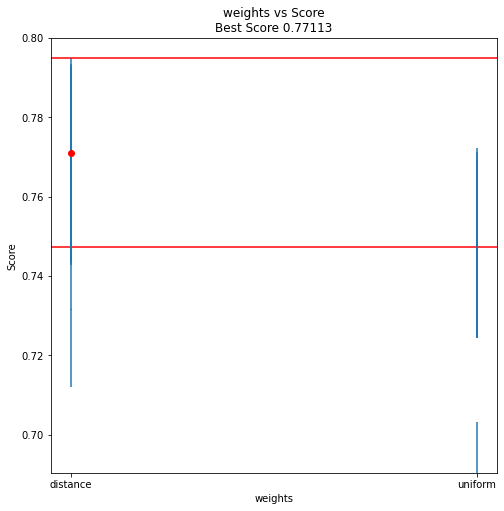

In [41]:
GridSearch_table_plot(knn_random, "weights", negative=False)

In [19]:
y_pred = knn.predict(data3d_X_test)
accuracy_score(y_test_resampled, y_pred)

0.6075949367088608

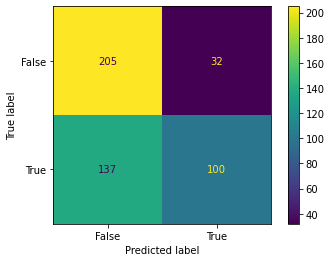

In [22]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test_resampled, smoothing(y_pred))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()


In [24]:
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test_resampled, smoothing(y_pred)))


 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       0.60      0.86      0.71       237
           1       0.76      0.42      0.54       237

    accuracy                           0.64       474
   macro avg       0.68      0.64      0.63       474
weighted avg       0.68      0.64      0.63       474



In [183]:
import pickle
with open('TSC_data/models_TSC/acc/KNN_TSC.pkl','wb') as f:
    pickle.dump(knn,f)

## TimeSeriesSVC

In [25]:
from tslearn.svm import TimeSeriesSVC
clf = TimeSeriesSVC(C=1.0, kernel="gak", gamma=0.001)
clf.fit(data3d_X_train,y_train_resampled)

TimeSeriesSVC(gamma=0.001)

In [26]:
y_pred = clf.predict(data3d_X_test)
accuracy_score(y_test_resampled, y_pred)

0.5

In [28]:
parameters = {'kernel': ['rbf', 'sigmoid'],
             'C': [1.0, 100.0, 1000.0],
             'gamma': [0.001, 0.01,0.1]}#


In [29]:
random_estimator = RandomizedSearchCV(estimator = clf,
                                   param_distributions = parameters,
                                   cv = 5,
                                   n_iter = 10,
                                   scoring = 'accuracy',
                                   n_jobs = -1,
                                   verbose = 1, 
                                   random_state = 1,
                                  )

random_estimator.fit(data3d_X_train, y_train_resampled)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=TimeSeriesSVC(), n_jobs=-1,
                   param_distributions={'C': [1.0, 100.0, 1000.0],
                                        'gamma': [0.001, 0.01, 0.1],
                                        'kernel': ['rbf', 'sigmoid']},
                   random_state=1, scoring='accuracy', verbose=1)

In [30]:
random_estimator.best_params_

best_estimator = random_estimator.best_estimator_

best_estimator.fit(data3d_X_train, y_train_resampled)

pred = best_estimator.predict(data3d_X_test)

accuracy_score(pred, y_test_resampled)

0.5

In [ ]:
GridSearch_table_plot(random_estimator, "gamma", negative=False)

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test_resampled, pred))

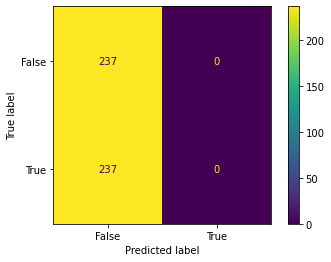

In [28]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test_resampled, smoothing(y_pred))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()

In [34]:
import pickle
with open('TSC_data/models_TSC/both/CLF_TSC.pkl','wb') as f:
    pickle.dump(clf,f)

In [61]:
print(2)

2


## Clustering TimeSeriesKMeans

In [91]:
from tslearn.clustering import TimeSeriesKMeans
km = TimeSeriesKMeans(n_clusters=2, metric="dtw")
labels = km.fit_predict(data3d_X_train)


km_bis = TimeSeriesKMeans(n_clusters=2, metric="softdtw")
labels_bis = km_bis.fit_predict(data3d_X_train)

In [86]:
pred_df = pd.DataFrame({"actual":y_train_resampled, "prediction":labels})